In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os

import arviz as az
import matplotlib.pyplot as plt
import neuromodels as nm
import numpy as np
import pandas as pd
import pylfi
import scipy.stats as stats
import seaborn as sns

[INFO] [2021.10.14 16:18:19 /Users/runner/miniforge3/conda-bld/nest-simulator_1633677025151/work/nestkernel/rng_manager.cpp:217 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2021.10.14 16:18:19 /Users/runner/miniforge3/conda-bld/nest-simulator_1633677025151/work/nestkernel/rng_manager.cpp:260 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-2.20.2
 Built: Oct  8 2021 07:17:41

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
size = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": size,
    "font.size": size,
    "legend.fontsize": size,
    "xtick.labelsize": size-1,
    "ytick.labelsize": size-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)
plt.rc('text', usetex=True)

# Set path to save the figures
FIGURE_PATH = "./../latex/figures" 

def fig_path(fig_id):
    """
    Input name of figure to load or save with extension as dtype str
    """
    return os.path.join(FIGURE_PATH + "/", fig_id)

# Set figure size
pt = 410 #360

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

fs = set_size(pt, fraction=1)
print(fs)

(5.673170056731701, 3.5062119190183605)


### Rejection algorithm: original vs. regression adjusted

In [3]:
# Simulator model
T = 120           # Simulation time [ms]
dt = 0.025        # Time step [ms]
I_amp = 10        # Input stimuls amplitude [microA/cm^2]
t_stim_on = 10    # Stimulus onset [ms]
t_stim_off = 110  # Stimulus offset [ms]
stimulus = nm.stimulus.Constant(I_amp, t_stim_on, t_stim_off)

hh = nm.models.HodgkinHuxley(stimulus, T, dt)

# Summary statistics calculator
s_stats = ["latency_to_first_spike",
           "average_AP_overshoot", 
           "average_AHP_depth"]

sps = nm.statistics.SpikeStats(t_stim_on=t_stim_on,
                               t_stim_off=t_stim_off,
                               stats=s_stats
                               )

# Observed data
gbarK0 = 36.
gbarNa0 = 120.
true_parameters = [gbarK0, gbarNa0]

V, t = hh(gbar_K=gbarK0, gbar_Na=gbarNa0)
obs_data = (V, t)

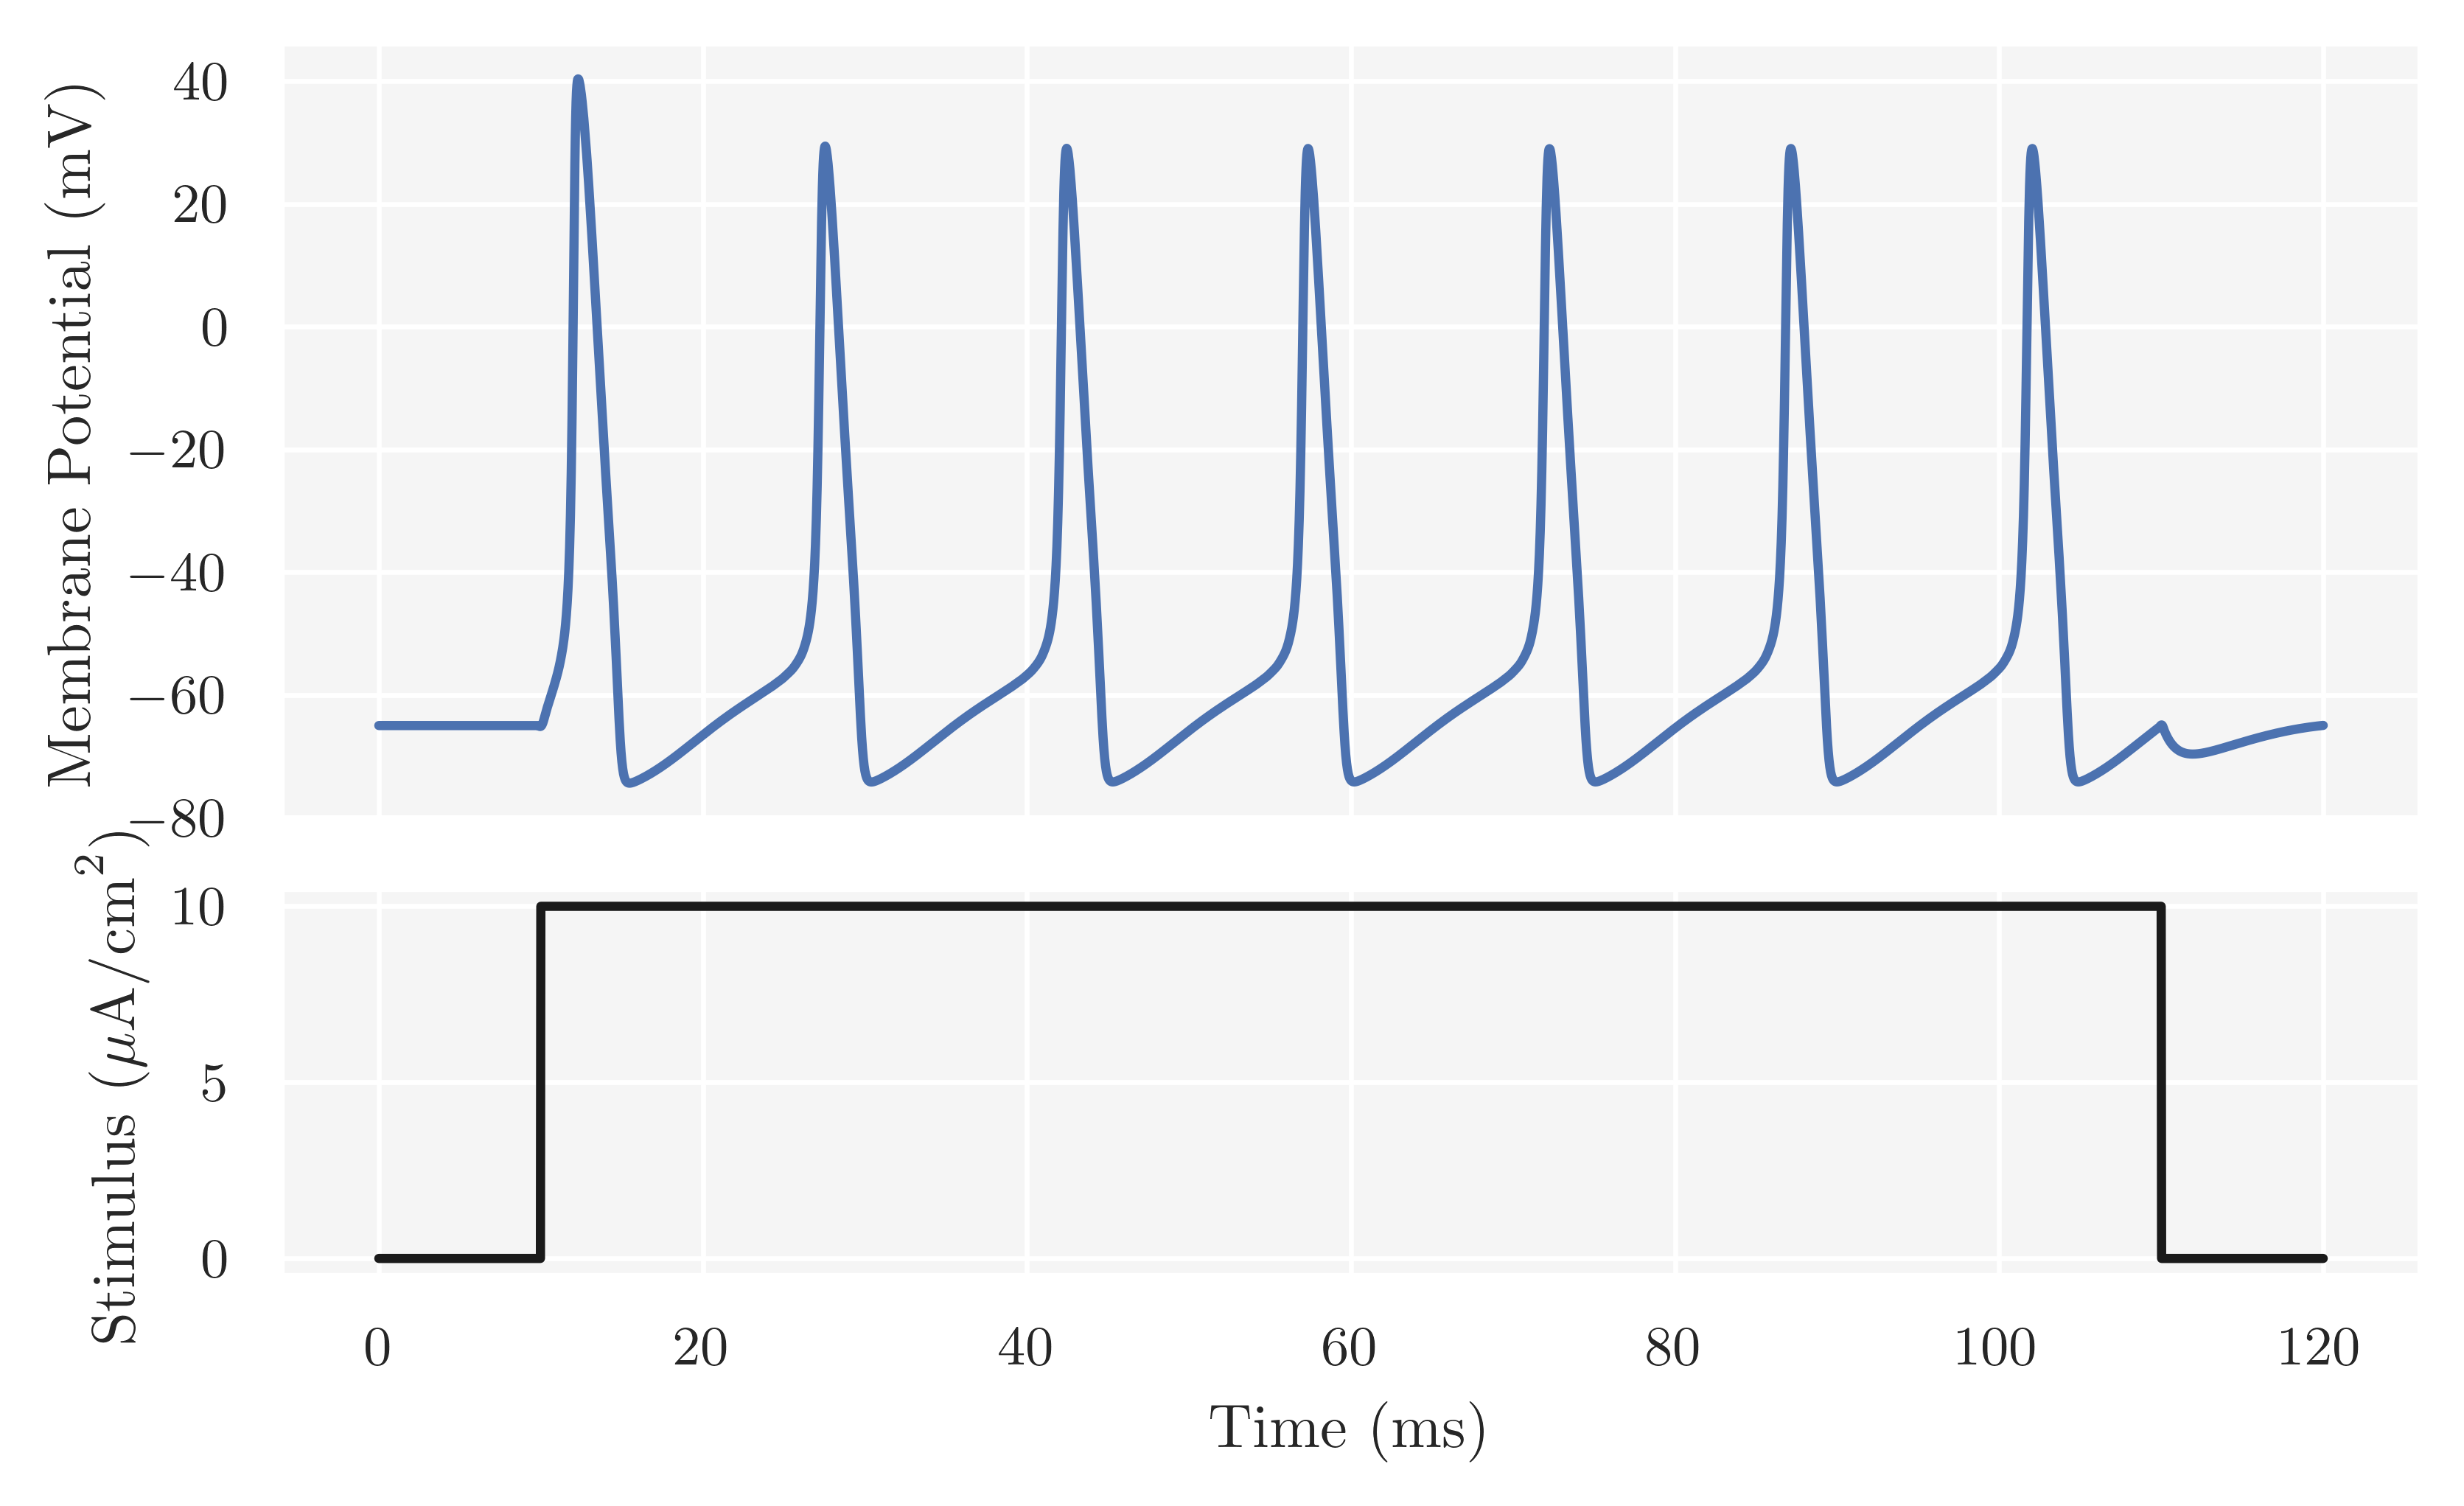

In [4]:
# Plot observation
hh.plot_voltage_trace(with_stim=True, figsize=fs, dpi=300)
plt.show()

#### Informative priors

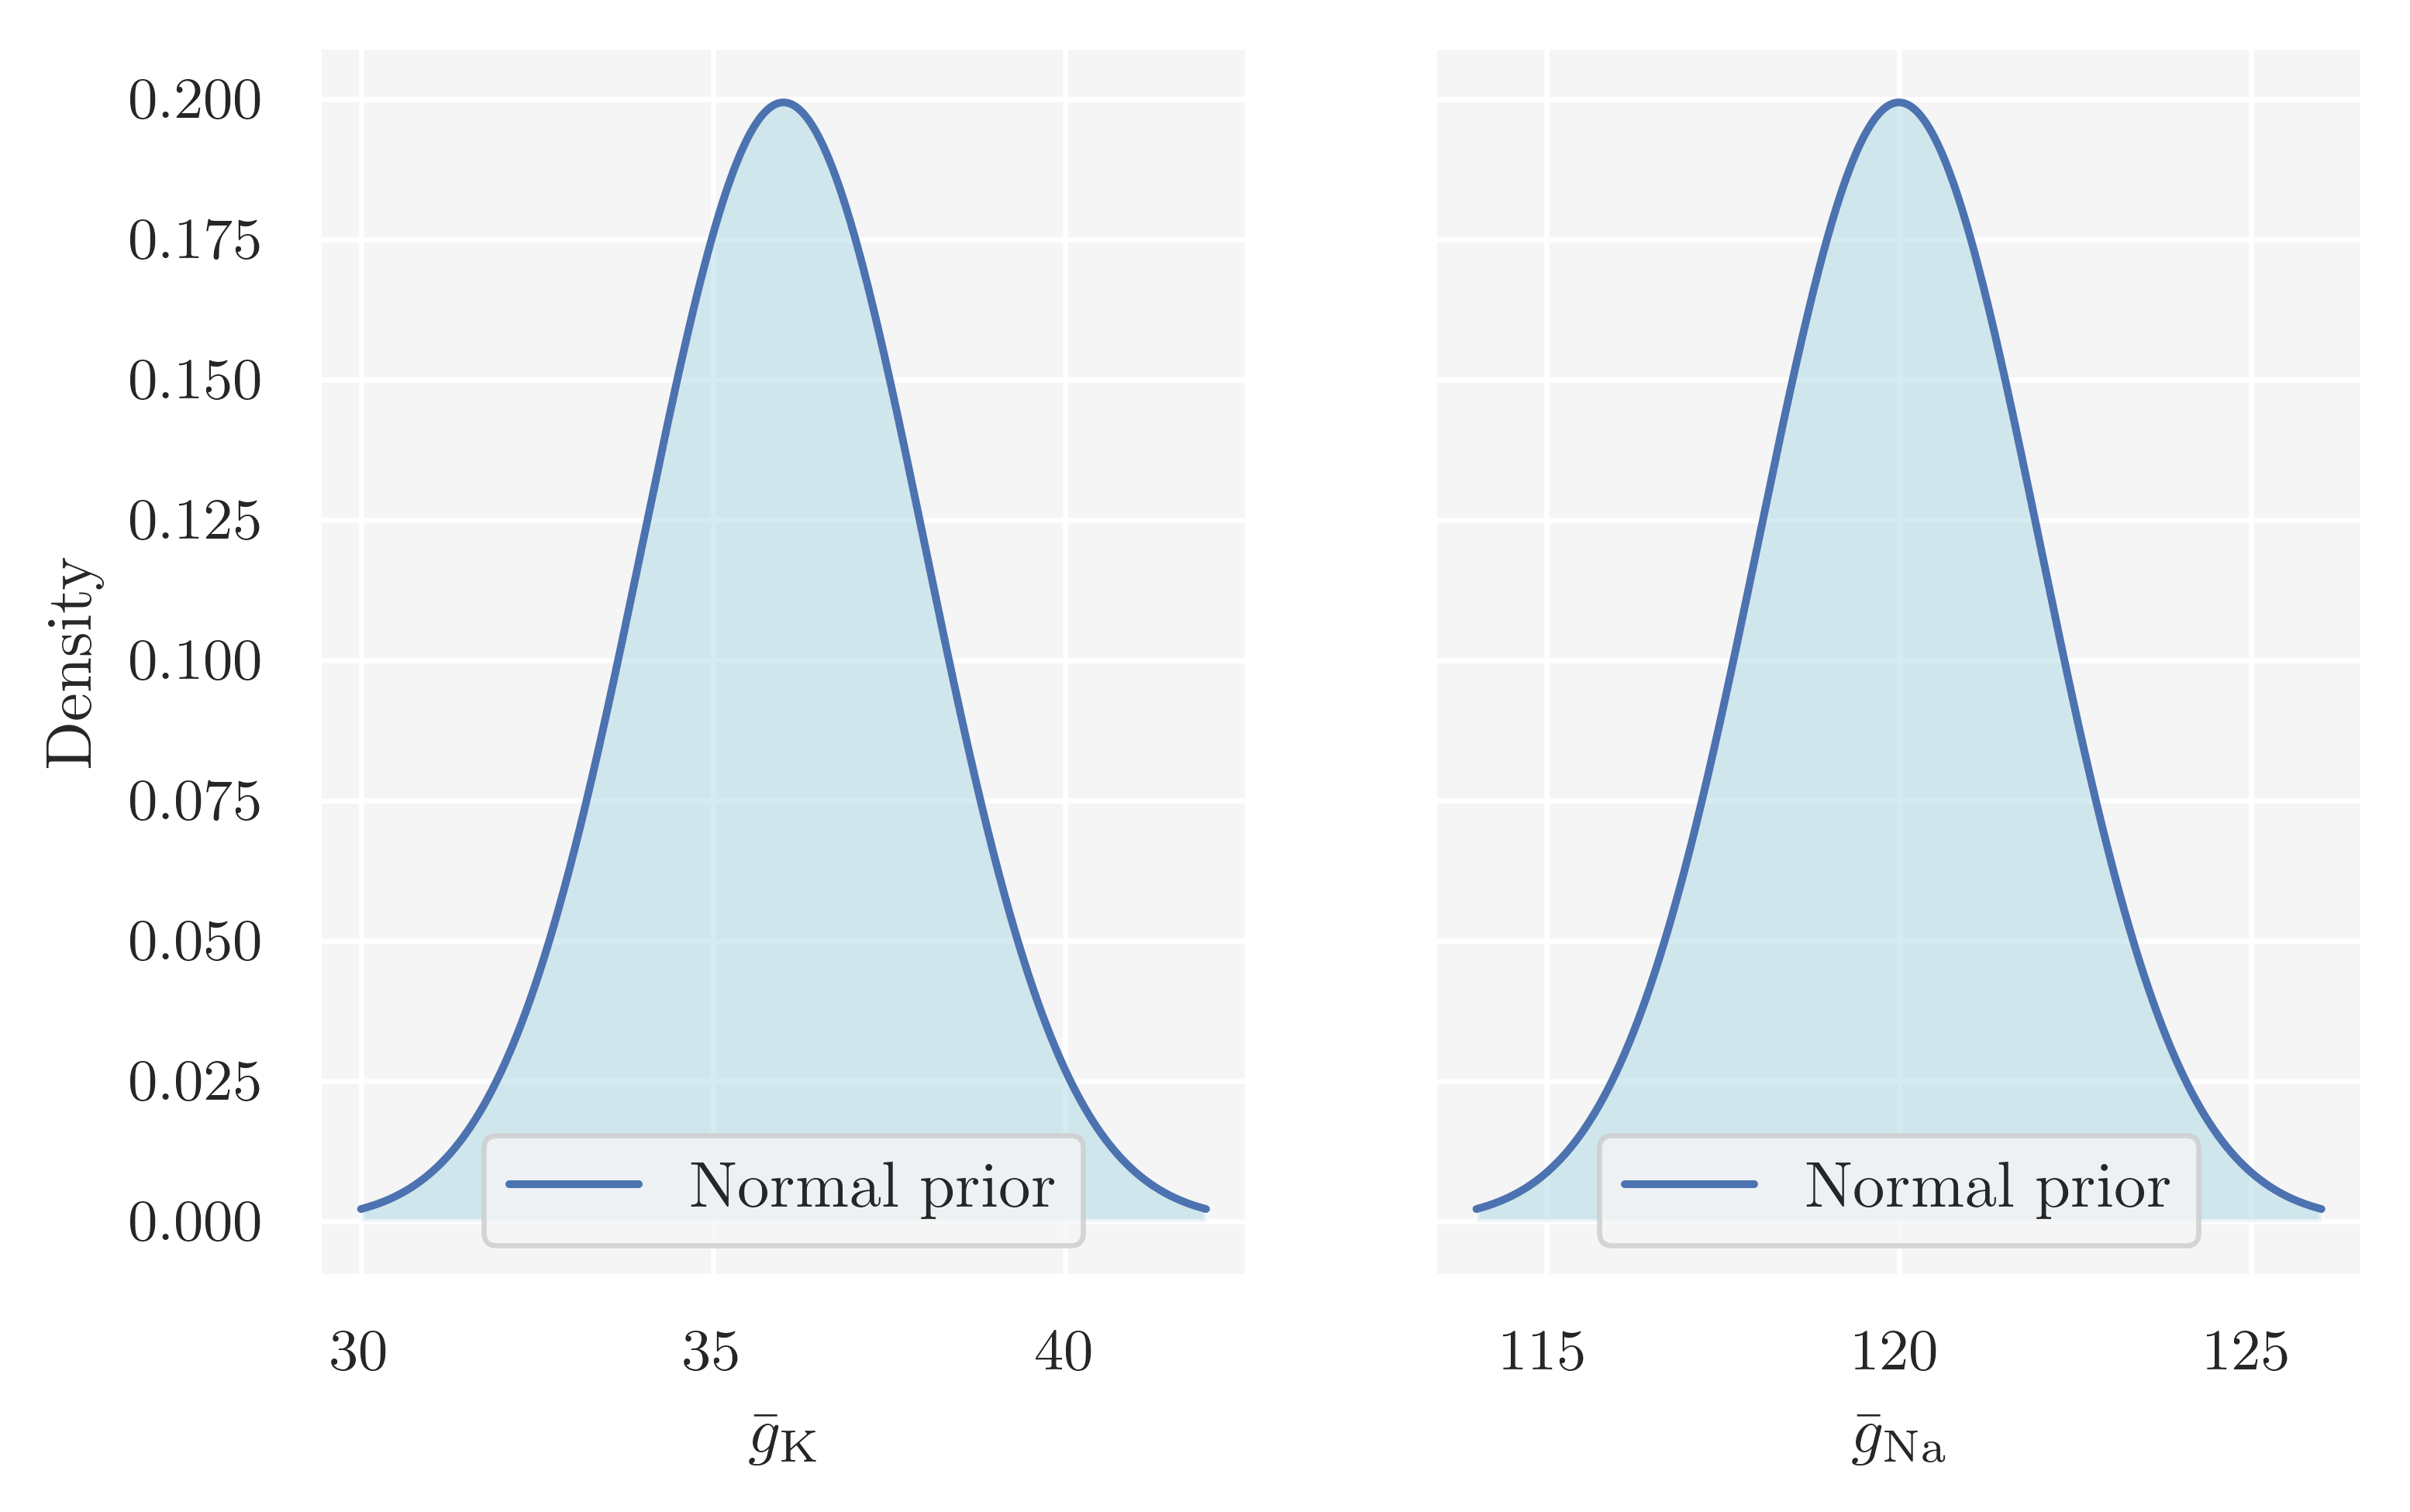

In [5]:
gbarK = pylfi.Prior('norm',
                     loc=gbarK0,
                     scale=2,
                     name='gbarK',
                     tex=r"$\bar{g}_\mathrm{K}$"
                     )

gbarNa = pylfi.Prior('norm',
                      loc=gbarNa0,
                      scale=2,
                      name='gbarNa',
                      tex=r"$\bar{g}_\mathrm{Na}$"
                      )

priors = [gbarK, gbarNa]

# Plot priors
fig, axes = plt.subplots(nrows=1, 
                         ncols=2, 
                         figsize=fs, 
                         dpi=300, 
                         sharey=True
                        )

x = np.linspace(30, 42, 1000)
gbarK.plot_prior(x, ax=axes[0], label="Normal prior")
axes[0].legend()

x = np.linspace(114, 126, 1000)
gbarNa.plot_prior(x, ax=axes[1], label="Normal prior")
axes[1].set_ylabel("")
axes[1].legend()

plt.show()

In [7]:
# Rejection ABC sampler
sampler = pylfi.RejABC(obs_data,
                       hh,
                       sps,
                       priors,
                       log=True
                       )

INFO:RejABC   Initialize Rejection ABC sampler.


In [9]:
# Pilot study 
sampler.pilot_study(2000,
                    quantile=0.5,
                    stat_scale="mad",
                    n_jobs=16,
                    seed=7
                    )

INFO:RejABC   Run pilot study to estimate:
* epsilon as the 0.5-quantile of the distances
* summary statistics scale (MAD) from the prior predictive distribution
INFO:RejABC   epsilon = 3.741629627675076
INFO:RejABC   mad = [0.025      0.81920528 0.06168999]


INFO:RejABC   Run rejection sampler.
INFO:RejABC   Write results to journal.


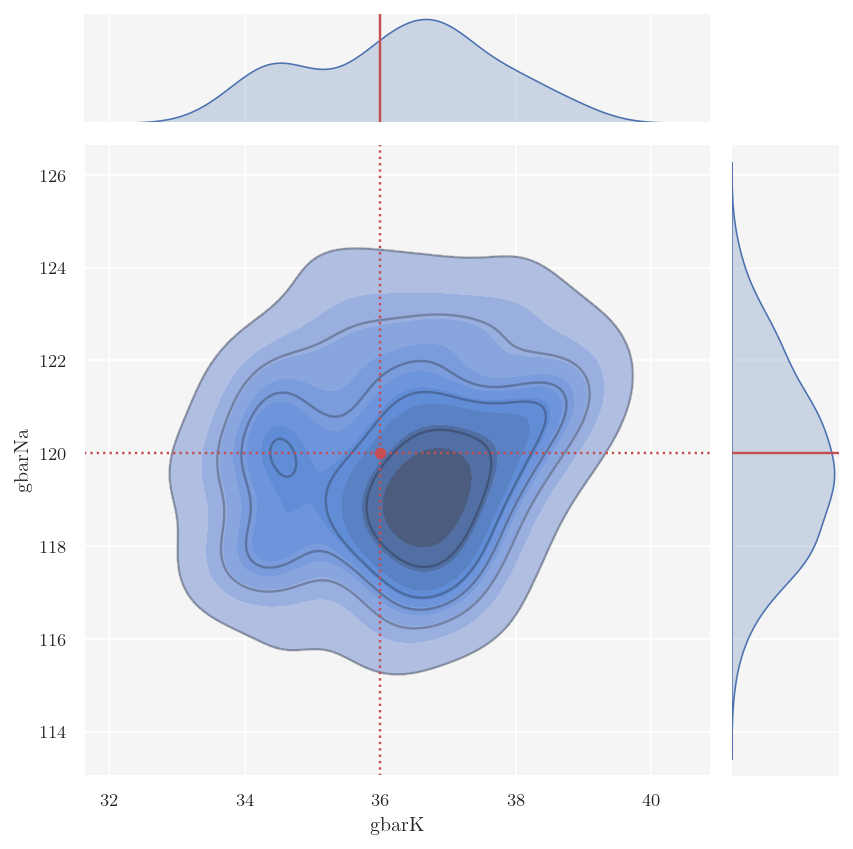

In [10]:
# Sample posterior
journal = sampler.sample(200,
                         use_pilot=True,
                         n_jobs=16,
                         seed=42,
                         return_journal=True
                         )

df = journal.df

g = sns.jointplot(data=df, x="gbarK", y="gbarNa", kind="kde", fill=True)
g.ax_joint.plot([gbarK0], [gbarNa0], 'ro')
g.ax_joint.axvline(gbarK0, color='r', ls=":")
g.ax_joint.axhline(gbarNa0, color='r', ls=":")
g.ax_marg_x.axvline(gbarK0, color='r')
g.ax_marg_y.axhline(gbarNa0, color='r')
g.plot_joint(sns.kdeplot, color="k", levels=6, alpha=0.3)

plt.show()

INFO:RejABC   Perform loclinear regression adjustment.
INFO:RejABC   Write results to journal.


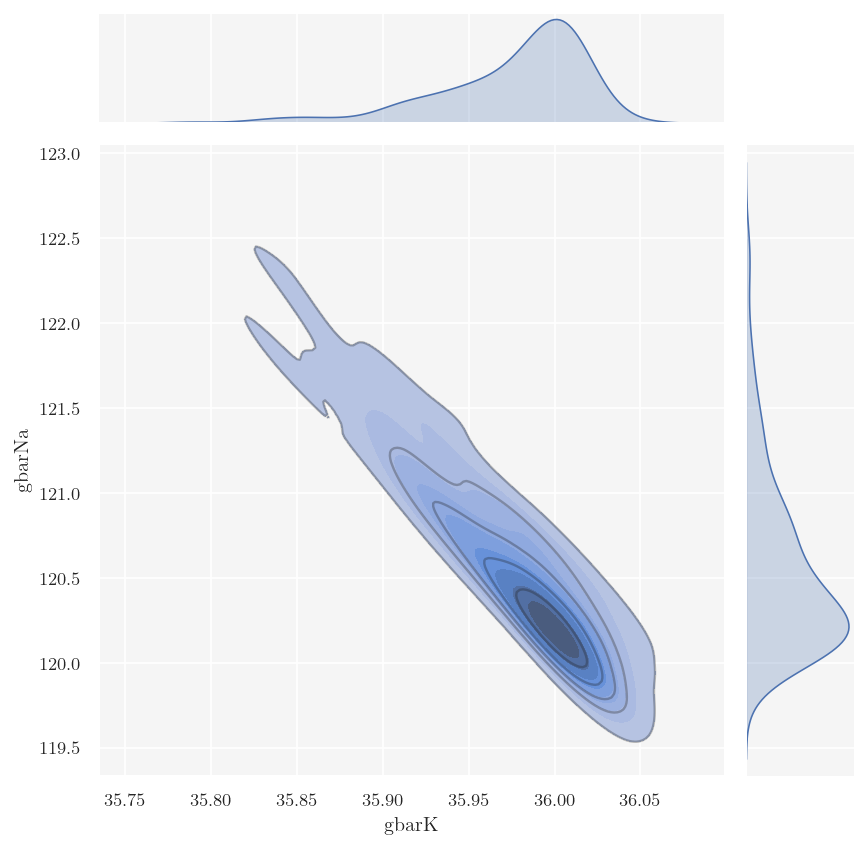

In [13]:
# Regression adjustment
journal2 = sampler.reg_adjust(method="loclinear",
                              transform=True,
                              return_journal=True
                              )

df2 = journal2.df

g = sns.jointplot(data=df2, x="gbarK", y="gbarNa", kind="kde", fill=True)
g.plot_joint(sns.kdeplot, color="k", levels=6, alpha=0.3)
plt.show()